To me, what would have made sense would have been to requantify GTEx with PODER and then get a sense of how many of the newly discovered transcripts were tissue specific or found in only a few tissues. The statement we are after is that most of the ancestyr-specif transcripts discoverted are tissue-specif (or more tissue-specif than the annotated ones! and so, we anticipate that this bias extends to many more tissues and cell types and needs to be fixed. The other way to do this would be  to look at hte tissue specificity distribution of the annotated transcripts that have similar expression levels as the newly discovered ones, show that the majority are tissue specific (which they probably will be) and then state since they have similar expression levels, we anticipate that many more ancestry-specific transcripts will be discovered once we  sequence more cell types and tissues

In [105]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [106]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [107]:
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table_fixed_genics.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [108]:
def compute_tau(df):
    """
    Compute tissue-specificity index for an abundance matrix output
    from `get_tpm_table`.
    """
    # number of samples 
    n = len(df.columns)
    print(f'Found {n} samples')
    
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # get max of TPM for transcript across samples
    temp = df.max(axis=1)
    temp_ind = temp.index.tolist()

    df = df.transpose()
    df_ind = df.columns.tolist()
    assert df_ind==temp_ind

    # compute x-hat (TPM / max TPM across tissues)
    x_hat = df/temp
    
    # compute (1-x-hat) 
    x_hat = 1-x_hat

    # compute sum across tissues
    x_hat = x_hat.transpose()
    x_hat['sum'] = x_hat.sum(axis=1)
    
    # compute tau for each transcript
    x_hat['tau'] = x_hat['sum']/n
    tau_df = x_hat[['tau']]
    
    return tau_df

In [109]:
f = expand(proc_cfg(config['gtex']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

# meta = load_meta()
# meta = meta.loc[meta.merged_run_mode==True]
# sample_d = dict([(entry.cell_line_id, entry['sample']) \
#                  for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.head()
df.columns = [d if d == 'transcript_id' else d.split('GTEx_v9_ONT_data_sequence_data_')[1].split('.')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
# # df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)


In [110]:
# https://academic.oup.com/bib/article/18/2/205/2562739
min_cpm = 1
min_samples = 1

# set all transcripts w/ expression <1 CPM --> 0
df[df < min_cpm] = 0

# remove all genes that are not expressed in at least one tissue
# the text must be wrong here because how can we filter 
# after log normalization for CPM >=1?
print(len(df.index))
df = df.loc[(df>=min_cpm).sum(axis=1)>=min_samples]
print(len(df.index))

# log-transform data and add 1 pseudocount
df = np.log2(df+1)

155875
95810


In [111]:
# add sample information so I can groupby different tissues
df = df.transpose()
meta_file = '/Users/fairliereese/Documents/programming/mele_lab/projects/240903_pt/snakemake/gtex_lr-kallisto/GTEx_v9_metadata_with_ancestry.txt'
meta = pd.read_csv(meta_file, sep='\t')
df = df.merge(meta[['sample_id', 'tissue']], how='left',
                  left_index=True, 
                  right_on='sample_id')

tissue_map = {'Brain - Frontal Cortex (BA9)': 'Brain',
              'Brain - Cerebellar Hemisphere': 'Brain',
              'Brain - Putamen (basal ganglia)': 'Brain',
              'Lung': 'Lung',
              'Heart - Left Ventricle': 'Heart',
              'Muscle - Skeletal': 'Muscle',
              'Brain - Anterior cingulate cortex (BA24)': 'Brain',
              'Heart - Atrial Appendage': 'Heart',
              'Brain - Caudate (basal ganglia)': 'Brain',
              'Adipose - Subcutaneous': 'Adipose', 
              'Cells - Cultured fibroblasts': 'Fibroblasts', 
              'Liver': 'Liver',
              'Breast - Mammary Tissue': 'Breast', 
              'Pancreas': 'Pancrease', 
              'K562': 'Lymphblasts'}
df['sample'] = df.tissue.map(tissue_map)

df.drop(['sample_id', 'tissue'], axis=1, inplace=True)

In [112]:
# compute the mean value per tissue
df = df.groupby('sample').mean()
df = df.transpose()

In [113]:
tau_df = compute_tau(df)

Found 10 samples


In [114]:
tau_df.index.name = 'tid'

In [115]:
tau_df.to_csv(f'241108_gtex_med_{min_cpm}_tau.tsv', sep='\t')

In [116]:
# add gene biotypes
tau_df = tau_df.merge(mt_df[['isoform', 'associated_gene_biotype']],
                      how='left', 
                      left_index=True,
                      right_on='isoform')

In [117]:
tau_df.set_index('isoform', inplace=True)
tau_df.index.name = 'tid'
# tau_df.head()

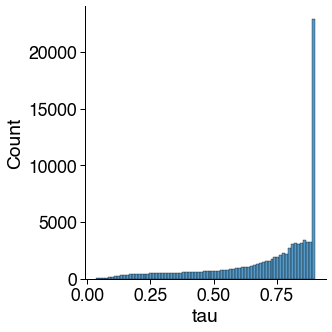

In [118]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', kind='hist')

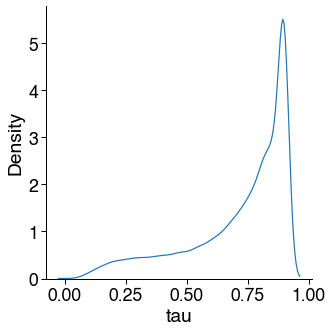

In [119]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', kind='kde')

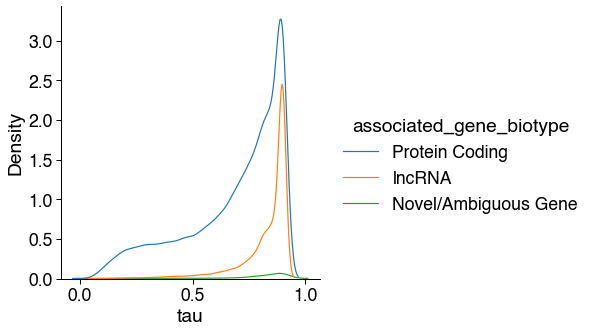

In [120]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', hue='associated_gene_biotype', kind='kde')

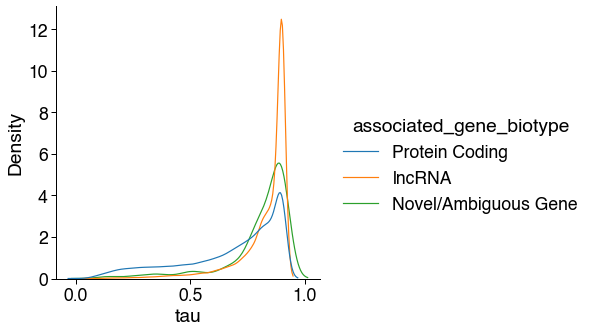

In [121]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', hue='associated_gene_biotype', kind='kde', common_norm=False)

In [122]:
tau_df.drop(['associated_gene_biotype'], axis=1, inplace=True)

In [123]:
tau_df['high_tau'] = tau_df.tau>=.8
tau_df.reset_index().groupby('high_tau').count()

,tid,tau
high_tau,,
False,49099,49099
True,46711,46711


## How tissue-specific are our population-specific transcripts?

 most of the ancestyr-specif transcripts discoverted are tissue-specif (or more tissue-specif than the annotated ones!

In [124]:
# read in the master table
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table_fixed_genics.tsv', sep='\t')
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)
mt_df.head()

,isoform,geneid.v,associated_gene_biotype,proteinv47_Chromosome,proteinv47_Start,proteinv47_Stop,proteinv47_Strand,proteinv47_Source,proteinv47_CDS_Source,proteinv47_CDS_Start,...,CDS_genomic_end,predicted_NMD,perc_A_downstream_TTS,seq_A_downstream_TTS,ORF_seq,annotated,predicted_ORF,proteinv47_predicted_ORF,associated_gene_biotype_sub,pop_spec_t
0,ENST00000741425.1,ENSG00000296732.1,lncRNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,35,TAAAGTTTTATAATCTTTTA,NaN,annotated,No ORF,No ORF,lncRNA,False
1,transcript_0,ENSG00000296732.1,lncRNA,GL000008.2,83369.0,130598.0,+,Cerberus,CPAT,83410.0,...,NaN,NaN,40,TAATGAGATTTATCAAAGGT,NaN,discovered,No ORF,Predicted ORF,lncRNA,False
2,transcript_1,ENSG00000296732.1,lncRNA,GL000008.2,83374.0,199915.0,+,Cerberus,CPAT,83410.0,...,NaN,NaN,35,GCAGCAAAATTTTTAGAGCT,NaN,discovered,No ORF,Predicted ORF,lncRNA,False
3,transcript_10,ENSG00000296732.1,lncRNA,GL000008.2,83404.0,199887.0,+,Cerberus,CPAT,83410.0,...,NaN,NaN,25,TTGTCAGTCCTTGATTTAAA,NaN,discovered,No ORF,Predicted ORF,lncRNA,False
4,transcript_11,ENSG00000296732.1,lncRNA,GL000008.2,83376.0,88830.0,+,Cerberus,CPAT,83410.0,...,NaN,NaN,25,GTTTACTTGCTTAACTAAGT,NaN,discovered,No ORF,Predicted ORF,lncRNA,False


In [125]:
tau_df.head()

,tau,high_tau
tid,,
ENST00000010132.6,0.298270,False
ENST00000075120.12,0.672459,False
ENST00000155093.8,0.673038,False
ENST00000156084.8,0.833381,True
ENST00000167825.5,0.272993,False


In [126]:
# merge in structural categories and pop spec stuff
tau_df = tau_df.reset_index()
tau_df = tau_df.merge(mt_df[['pop_spec_t', 'structural_category', 'isoform']],
                      how='left',
                      left_on='tid', 
                      right_on='isoform')

In [127]:
tau_df.loc[tau_df.tau.isnull()]

,tid,tau,high_tau,pop_spec_t,structural_category,isoform


Tissue specificity of population-specific transcripts are greater than non-population specific
Wilcoxon rank-sum test statistic: 11.379966391143737
Wilcoxon rank-sum test pval: 2.6310003582971422e-30


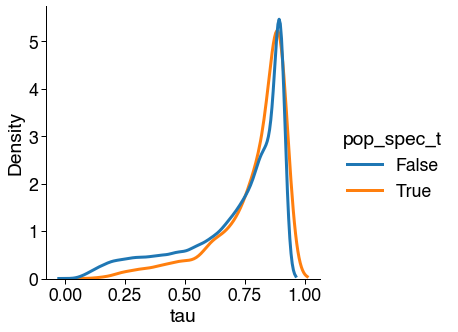

In [128]:
# are population-specific transcripts also more tissue-specific?
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', 
            hue='pop_spec_t',
            kind='kde',
            linewidth=3,
            common_norm=False)

# test - unpaired, pop-spec tau > non pop-spec tau
x = tau_df.loc[tau_df.pop_spec_t == True, 'tau'].tolist() # hypothesis is that this is greater
y = tau_df.loc[tau_df.pop_spec_t == False, 'tau'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')

print('Tissue specificity of population-specific transcripts are greater than non-population specific')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

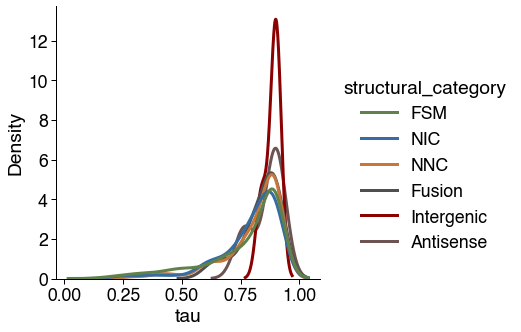

In [129]:
# are population-specific transcripts by novelty category more or less tissue-specific?
init_plot_settings(aspect='square')
temp = tau_df.loc[tau_df.pop_spec_t==True].copy(deep=True)
c_dict, order = get_novelty_colors()
sns.displot(temp, x='tau', 
            hue='structural_category',
            kind='kde',
            linewidth=3,
            common_norm=False, 
            palette=c_dict)

Tissue specificity of NOVEL population-specific transcripts are greater than KNOWN population-specific
Wilcoxon rank-sum test statistic: 1.2129332840867817
Wilcoxon rank-sum test pval: 0.11257766446036205


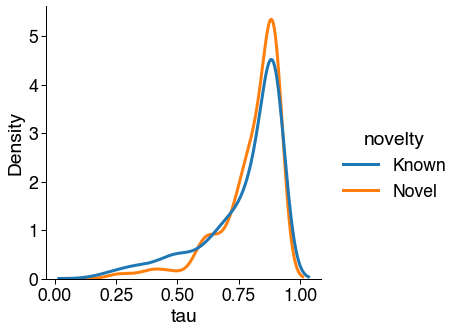

In [130]:
# are population-specific transcripts by known / novel category more or less tissue-specific?
init_plot_settings(aspect='square')
temp = tau_df.loc[tau_df.pop_spec_t==True].copy(deep=True)
temp['novelty'] = 'Novel'
temp.loc[temp.structural_category == 'FSM', 'novelty'] = 'Known'
sns.displot(temp, x='tau', 
            hue='novelty',
            kind='kde',
            linewidth=3,
            common_norm=False)

# test - unpaired, pop-spec tau novel >  pop-spec tau known
x = temp.loc[temp.novelty == 'Novel', 'tau'].tolist() # hypothesis is that this is greater
y = temp.loc[temp.novelty == 'Known', 'tau'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')

print('Tissue specificity of NOVEL population-specific transcripts are greater than KNOWN population-specific')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

In [131]:
# if we simply apply a 0.8 threshold to call somethin tissue-specifc
# and look at the proportion per novelty
temp['tissue_spec'] = temp.tau >= 0.8
temp3 = temp[['tid', 'tissue_spec', 'novelty']].groupby(['novelty', 'tissue_spec']).count().reset_index().rename({'tid':'n_t'}, axis=1)
temp2 = temp[['tid', 'novelty']].groupby(['novelty']).count().reset_index().rename({'tid':'n_total_t'}, axis=1)
temp3 = temp3.merge(temp2, how='left', on='novelty')
temp3['perc'] = (temp3['n_t']/temp3['n_total_t'])*100
temp3

,novelty,tissue_spec,n_t,n_total_t,perc
0,Known,False,266,674,39.465875
1,Known,True,408,674,60.534125
2,Novel,False,166,474,35.021097
3,Novel,True,308,474,64.978903


## How tissue-specific are our novel transcripts?

 most of the ancestyr-specif transcripts discoverted are tissue-specif (or more tissue-specif than the annotated ones!

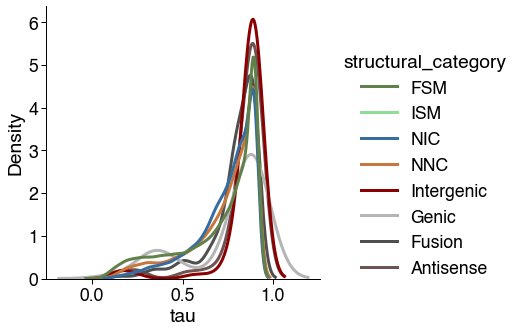

In [132]:
init_plot_settings(aspect='square')
c_dict, order = get_novelty_colors()
sns.displot(tau_df, x='tau',
            hue='structural_category',
            kind='kde', common_norm=False,
            palette=c_dict, hue_order=order,
            linewidth=3)

In [133]:
tau_df['novelty'] = 'Novel'
tau_df.loc[tau_df.structural_category == 'FSM', 'novelty'] = 'Known'

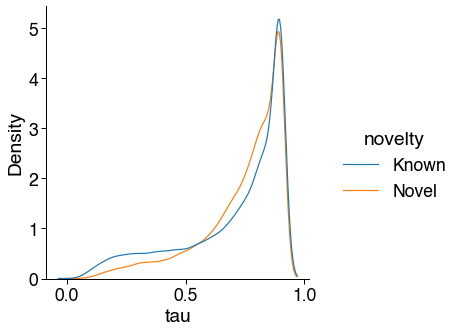

In [134]:
init_plot_settings(aspect='square')
c_dict, order = get_novelty_colors()
sns.displot(tau_df, x='tau',
            hue='novelty',
            kind='kde', common_norm=False)

In [137]:
# are novel transcripts more or less tissue-specific?

# test - unpaired, pop-spec tau novel >  pop-spec tau known
x = tau_df.loc[tau_df.novelty == 'Novel', 'tau'].tolist() # hypothesis is that this is greater
y = tau_df.loc[tau_df.novelty == 'Known', 'tau'].tolist()

stat, pval = st.ranksums(x, y, alternative='greater')

print('Tissue specificity of novel transcripts are greater than known')
print(f'Wilcoxon rank-sum test statistic: {stat}')
print(f'Wilcoxon rank-sum test pval: {pval}')

Tissue specificity of novel transcripts are greater than known
Wilcoxon rank-sum test statistic: 9.100646745156402
Wilcoxon rank-sum test pval: 4.489774946033628e-20


In [136]:
# if we simply apply a 0.8 threshold to call somethin tissue-specifc
# and look at the proportion per novelty
tau_df['tissue_spec'] = tau_df.tau >= 0.8
temp = tau_df[['tid', 'tissue_spec', 'novelty']].groupby(['novelty', 'tissue_spec']).count().reset_index().rename({'tid':'n_t'}, axis=1)
temp2 = tau_df[['tid', 'novelty']].groupby(['novelty']).count().reset_index().rename({'tid':'n_total_t'}, axis=1)
temp = temp.merge(temp2, how='left', on='novelty')
temp['perc'] = (temp['n_t']/temp['n_total_t'])*100
temp

,novelty,tissue_spec,n_t,n_total_t,perc
0,Known,False,34731,67462,51.482316
1,Known,True,32731,67462,48.517684
2,Novel,False,14368,28348,50.684352
3,Novel,True,13980,28348,49.315648


<!-- ## What do tissue specificity values look like based on expression levels of the transcripts based on our data in GTEx?  

Split by known vs. novel, as well as by population specific or not -->

<!-- look at hte tissue specificity distribution of the annotated transcripts that have similar expression levels as the newly discovered ones, show that the majority are tissue specific (which they probably will be) and then state since they have similar expression levels, we anticipate that many more ancestry-specific transcripts will be discovered once we  sequence more cell types and tissues -->